#### Ace0 model comparison

In [1]:
%load_ext autoreload
%autoreload 2

import os
import traceback
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import torch

import gpytorch
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer import Predictive
from gpytorch.kernels import ScaleKernel, RBFKernel, PeriodicKernel, \
    LinearKernel, ProductKernel, AdditiveKernel, MaternKernel, SpectralMixtureKernel, \
        PiecewisePolynomialKernel, PolynomialKernel, RQKernel, RFFKernel
from gpytorch.priors import GammaPrior, HorseshoePrior

import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.insert(0,"../../")

import itertools
import collections
from adjustText import adjust_text
import arviz as az
import xarray as xr

# from modules.HetMOGP import HetMOGP
from modules.additive_hmogp import HetMOGP
from modules.prior import UniformPrior, BetaPrior
from modules.metrics import mean_sum_composition_errors, scotts_pi
from modules.stats_utils import compute_nlpd, compute_log_likelihood
from modules.cdaf import plot_cdaf
import scipy.stats as st

# set plotting theme
from matplotlib.ticker import MultipleLocator
from cycler import cycler
plt.style.use('default')
# color_cycle = ['#348ABD', '#E24A33', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
# default_color_cycle = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
rcparam_update = {
    "axes.titlesize": 'large',
    "axes.labelsize": 12,
    "figure.labelsize": "large", 
    "figure.titlesize": "large",
    'legend.fontsize': 10,
    'legend.title_fontsize': 'large',
    'xtick.labelsize': 12,
    'ytick.labelsize': 10,
    # 'axes.prop_cycle': cycler('color', color_cycle),
    'axes.facecolor': '#fdfdff',
    "font.family": "FreeSans",
    'figure.figsize': [6.4, 4.8], # default
}
plt.rcParams.update(rcparam_update)
save_image_path = "/mnt/c/Users/huyca/OneDrive/Thesis_tex/Figures/ace0/model"
dpi = 600
savefig = False
kernel_n = "3_n_6"

from matplotlib import ticker
n_ticks = 4

#### Setup data

In [2]:
test_id = {
    0: "SA-HMOGP",
    1: "A-HMOGP",
    2: "IA-GGP",
    3: "HMOGP",
}

# palette = {
#     "SA-HMOGP": "#360332",
#     "A-HMOGP": '#c989c4',
#     "IA-GGP": "#4A5492",
#     "HMOGP": "#6F499D",
# }

palette = {
    "SA-HMOGP": "#360332",
    "A-HMOGP": '#BFADD5',
    "IA-GGP": "#3566AF",
    "HMOGP": "#E1B2B2",
}

In [3]:
def is_numeric(x):
        return isinstance(x,(np.int32, np.float32, np.int64, np.float64, int, float))

def adjust_kernel_id(kernel_id, n_kernels):
        new_kernel_id = n_kernels + ((kernel_id+1)/10)
        return new_kernel_id

def geometric_mean(x):
        gm = np.exp(np.log(x).mean())
        return np.round(gm, 4)

def compute_geometric_mean(df, cols, new_col_name):
        df[cols] = df[cols].apply(lambda x: x + np.abs(np.min(x)) + 1 if np.min(x) < 0 else x)
        df[new_col_name] = df[cols].apply(lambda x: geometric_mean(x), axis=1)
        return df

def get_csv_path(n_kernels, version=1):
        csv_path = f"./model_comparisons_v{version}/kernels_len_{n_kernels}/"
        return csv_path

In [4]:
class Metrics:
    
    def __init__(self, path, n_kernels):
        self.path = path
        self.n_kernels = n_kernels
        
        _csv_files = os.listdir(self.path)
        _csv_files = [csv for csv in _csv_files if csv.endswith(".csv")]
        self.variable_list = [csv.replace("_df.csv", "") for csv in _csv_files]
        
        test_id = {
            0: "SA-HMOGP",
            1: "A-HMOGP",
            2: "IA-GGP",
            3: "HMOGP",
            4: "SA-HMOGP",
            5: "HMOGP",
        }
        
        for variable, csv in zip(self.variable_list, _csv_files):
            variable_name = variable
            df = pd.read_csv(os.path.join(path, csv), index_col=0)
            df.test_id = df.test_id.apply(lambda x: test_id[x] if is_numeric(x) else x)
            df.kcid = df.kcid.apply(lambda x: adjust_kernel_id(x, self.n_kernels))
            if "msce" in variable_name:
                cols = ["y1", "y2"]
                df["mean"] = df[cols].apply(lambda x: x.mean(), axis=1)
            elif "agreement" in variable_name:
                cols = ["y0", "y3", "y4"]
                df["mean"] = df[cols].apply(lambda x: x.mean(), axis=1)
            setattr(self, variable, df)

            if "waic" in variable_name:
                cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']
                df_gm = df.copy()
                df_gm = compute_geometric_mean(df_gm, cols, "adj_elpd_waic")
                setattr(self, variable_name + "_gm", df_gm)
                self.variable_list.append(variable_name + "_gm")
            elif "nlpd" in variable_name:
                cols = ['y0', 'y1', 'y2', 'y3', 'y4']
                df_gm = df.copy()
                df_gm = compute_geometric_mean(df_gm, cols, "adj_nlpd")
                setattr(self, variable_name + "_gm", df_gm)
                self.variable_list.append(variable_name + "_gm")
                
    def compare_baseline(self, metric:str, kernel_id):
        assert metric in self.variable_list
        df = getattr(self, metric)
        cond = (df.test_id.isin(["SA-HMOGP", "HMOGP"]))
        if metric == "agreement":
            cond &= df.weight == "quadratic"
        if isinstance(kernel_id, float):
            cond &= df.kcid == kernel_id
        elif isinstance(kernel_id, list):
            cond &= df.kcid.isin(kernel_id)
        else:
            raise ValueError("invalid kernel id.")
        return df[cond]

In [5]:
metrics2 = Metrics(get_csv_path(2), 2)
metrics3 = Metrics(get_csv_path(3), 3)
metrics6 = Metrics(get_csv_path(6), 6)
metrics9 = Metrics(get_csv_path(9), 9)
metrics18 = Metrics(get_csv_path(18), 18)

agreement_cols = ["y0", "y3", "y4"]
agreement = pd.concat([
    metrics3.agreement,
    metrics6.agreement,
])
agreement = agreement.reset_index(drop=True)

msce_cols = ["y1", "y2"]
msce = pd.concat([
    metrics3.msce,
    metrics6.msce,
])
msce = msce.reset_index(drop=True)

waic = pd.concat([
    metrics3.waic,
    metrics6.waic,
])
waic = waic.reset_index(drop=True)

waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']
waic_gm = waic.copy()
waic_gm = compute_geometric_mean(waic_gm, waic_cols, "adj_elpd_waic")

nlpd = pd.concat([
    metrics3.nlpd,
    metrics6.nlpd,
])
nlpd = nlpd.reset_index(drop=True)

nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4']
cols = ['y0', 'y1', 'y2', 'y3', 'y4']
nlpd_gm = nlpd.copy()
nlpd_gm = compute_geometric_mean(nlpd_gm, nlpd_cols, "adj_nlpd")

kcid3 = metrics3.nlpd.kcid.unique()
kcid6 = metrics6.nlpd.kcid.unique()

kcid = [kcid3, kcid6]

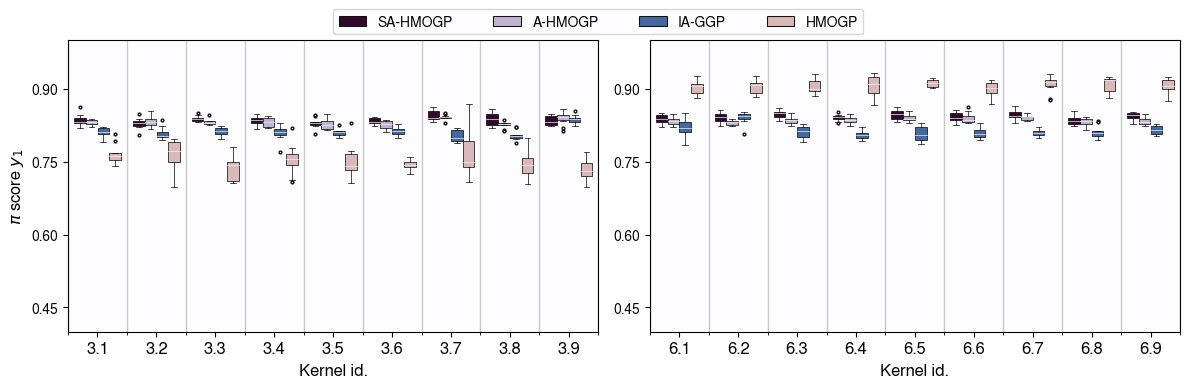

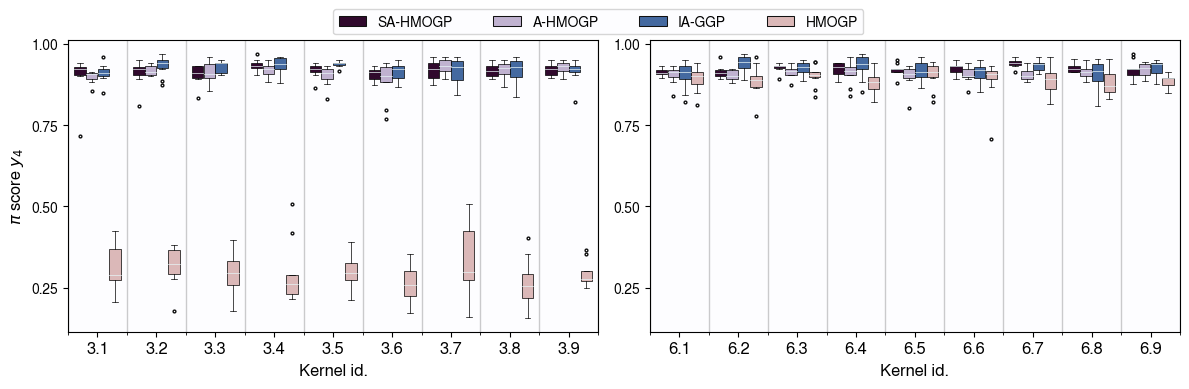

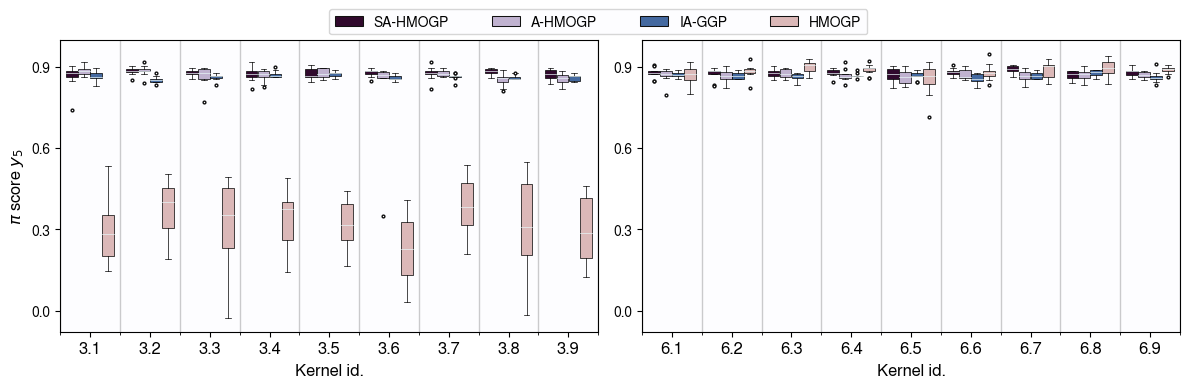

In [6]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
idx = [1,4,5]

for d, y, in zip(idx, agreement_cols):
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
    for i, kcid_n in enumerate(kcid):
        sns.boxplot(data=agreement[(agreement.weight=="quadratic") & (agreement.kcid.isin(kcid_n))], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
        ax[i].get_legend().remove()
        
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
        ax[i].set_xlabel("Kernel id.")
        ax[i].set_ylabel("")                    # added
        yticks = ticker.MaxNLocator(n_ticks)    # added
        ax[i].yaxis.set_major_locator(yticks)   # added
        
        if d == 1:
            ax[i].set_ylim(.4,1)
    ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    ax[0].set_ylabel(r"$\pi$ score $y_{}$".format(d))      # added
    
    for axis in ax.flatten():
        axis.yaxis.set_tick_params(labelleft=True)
    
    fig.tight_layout()
    
    if savefig:
        fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y{d}_agreement.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

(0.277115, 0.9617183333333335)


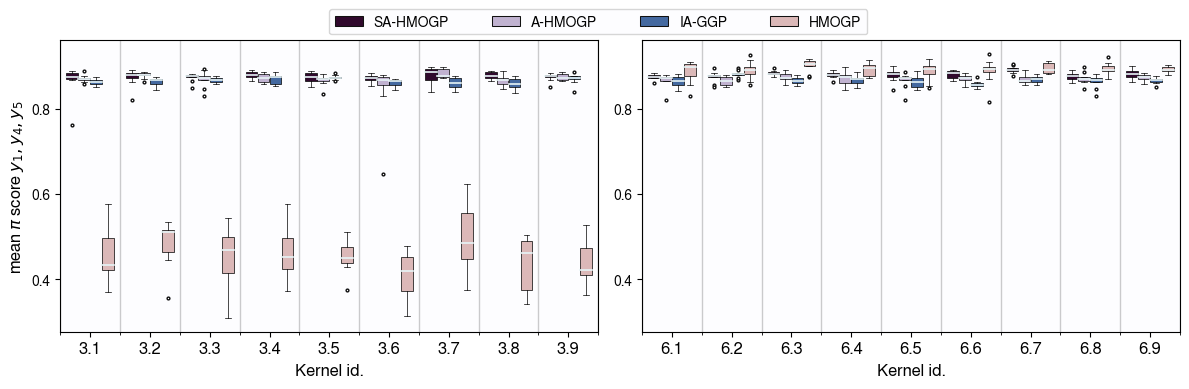

In [27]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':1.2, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=agreement[(agreement.weight=="quadratic") & (agreement.kcid.isin(kcid_n))], x="kcid", y="mean", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"mean $\pi$ score $y_1, y_4, y_5$")
for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
    
fig.tight_layout()
print(ax[0].get_ylim())
if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_agreement_mean.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

HD: calculate coefficient of variation

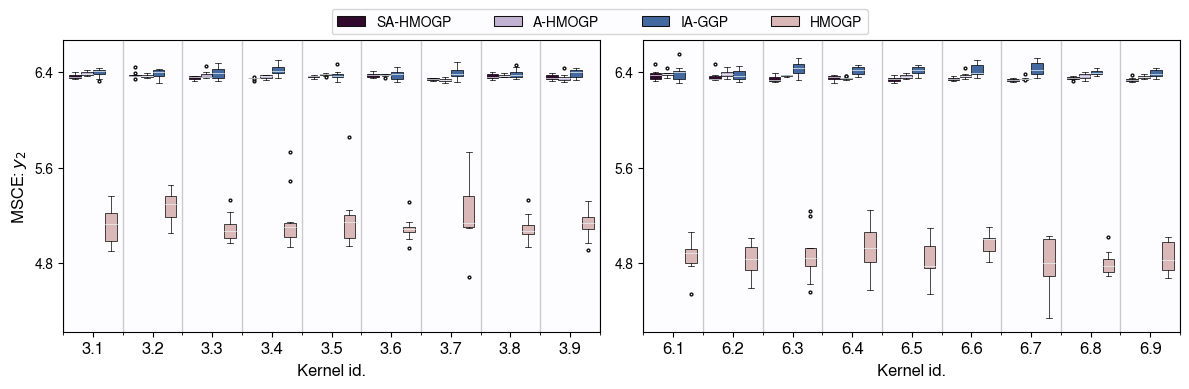

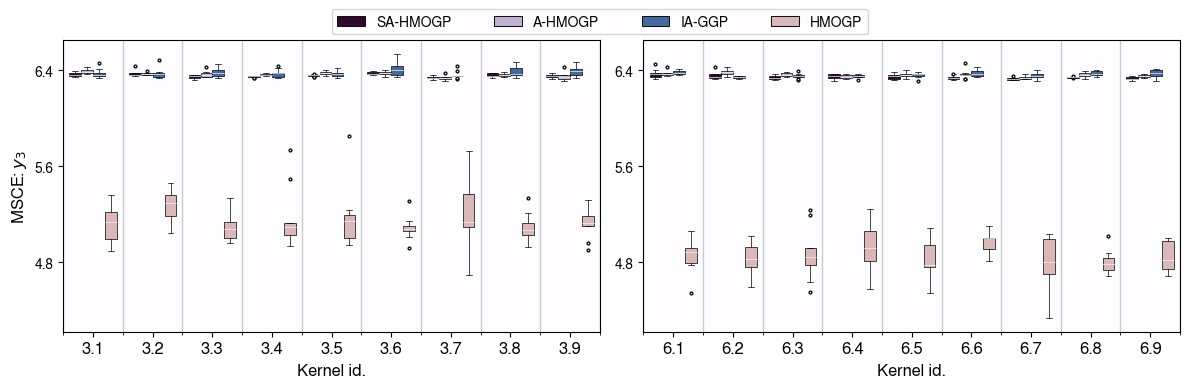

In [8]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
msce_cols = ["y1", "y2"]
for idx, y in enumerate(msce_cols, start=2):
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
    for i, kcid_n in enumerate(kcid):
        sns.boxplot(data=msce[msce.kcid.isin(kcid_n)], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
        ax[i].get_legend().remove()
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
        ax[i].set_xlabel("Kernel id.")
        ax[i].set_ylabel("")                    # added
        yticks = ticker.MaxNLocator(n_ticks)    # added
        ax[i].yaxis.set_major_locator(yticks)   # added

    ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    ax[0].set_ylabel(r"MSCE: $y_{}$".format(idx))      # added
    
    for axis in ax.flatten():
        axis.yaxis.set_tick_params(labelleft=True)
    
    fig.tight_layout()
    
    if savefig:
        fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y{idx}_msce.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

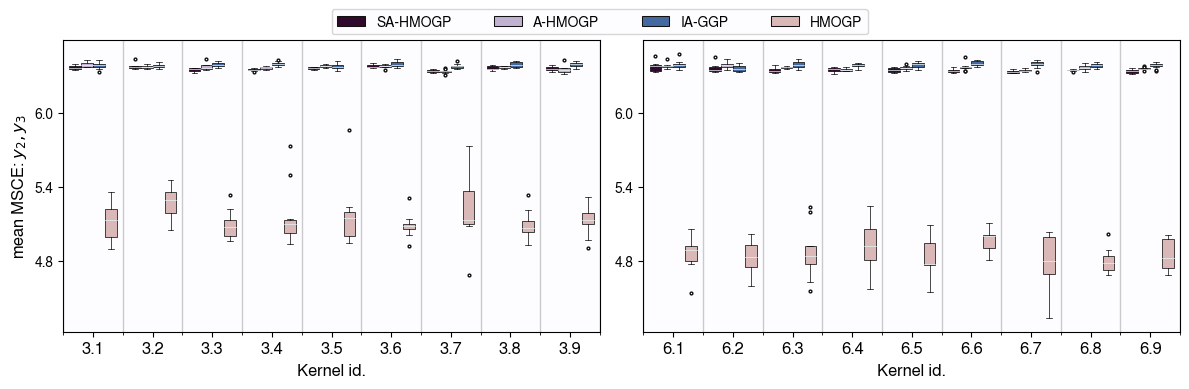

In [9]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=msce[msce.kcid.isin(kcid_n)], x="kcid", y="mean", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"mean MSCE: $y_2, y_3$")
for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_msce_gm.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

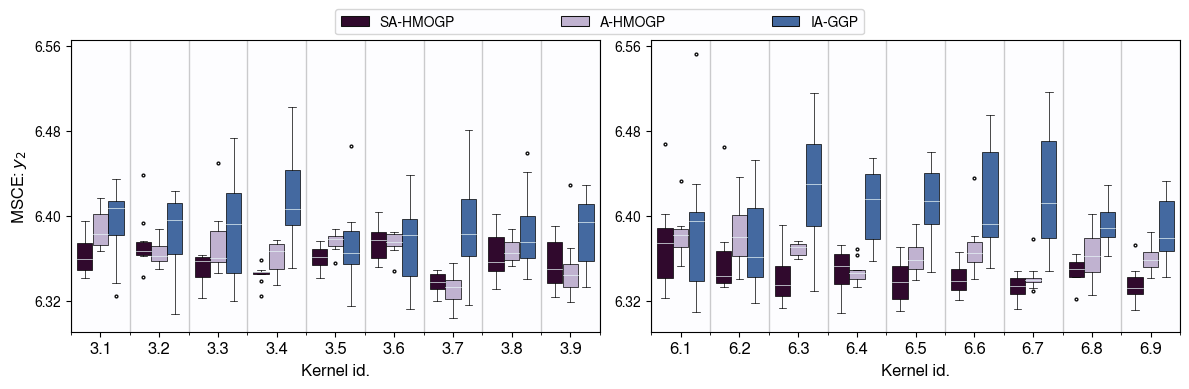

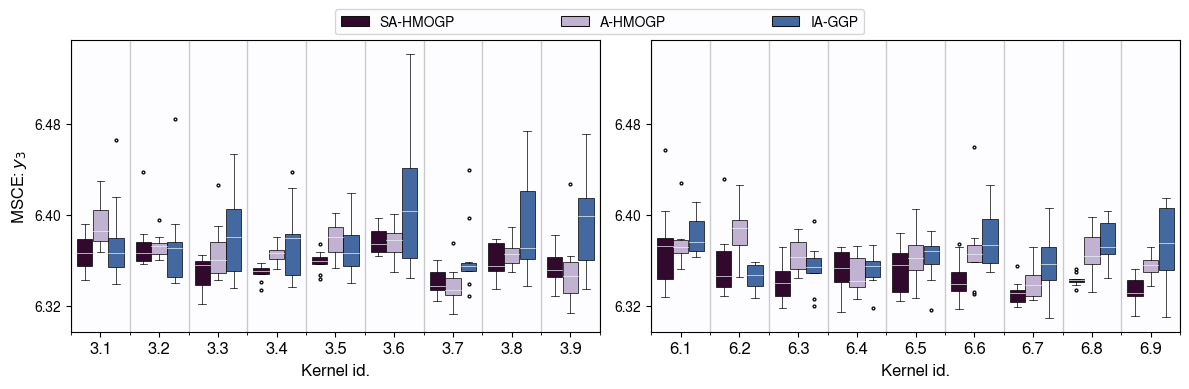

In [10]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
msce_cols = ["y1", "y2"]
for idx, y in enumerate(msce_cols, start=2):
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
    for i, kcid_n in enumerate(kcid):
        sns.boxplot(data=msce[(msce.kcid.isin(kcid_n)) & (msce.test_id != "HMOGP")], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
        ax[i].get_legend().remove()
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
        ax[i].set_xlabel("Kernel id.")
        ax[i].set_ylabel("")                    # added
        yticks = ticker.MaxNLocator(n_ticks)    # added
        ax[i].yaxis.set_major_locator(yticks)   # added

    ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    ax[0].set_ylabel(r"MSCE: $y_{}$".format(idx))      # added
    
    for axis in ax.flatten():
        axis.yaxis.set_tick_params(labelleft=True)
    
    fig.tight_layout()
    
    if savefig:
        fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y{idx}_msce_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

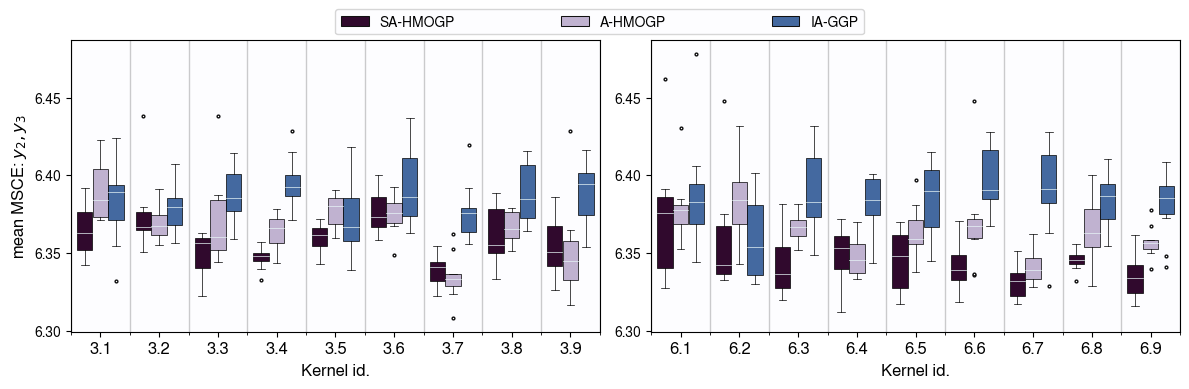

In [11]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=msce[(msce.kcid.isin(kcid_n)) & (msce.test_id != "HMOGP")], x="kcid", y="mean", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"mean MSCE: $y_2, y_3$")
for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_msce_gm_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

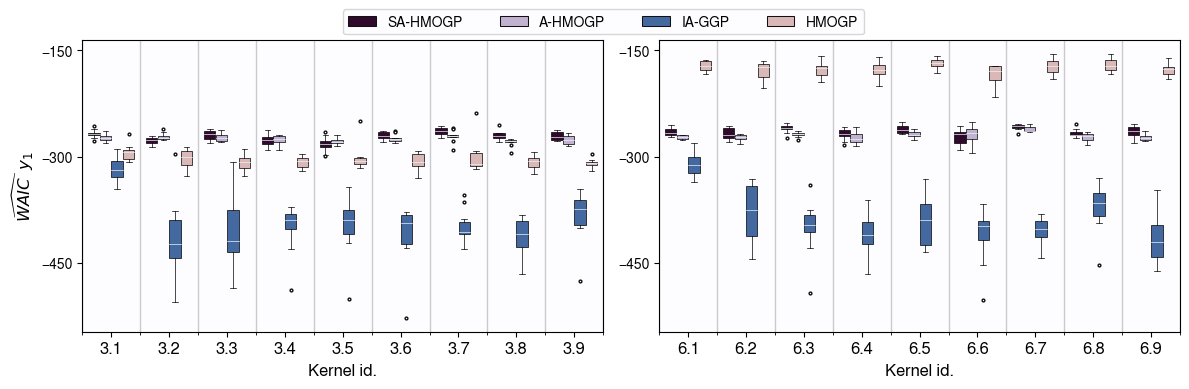

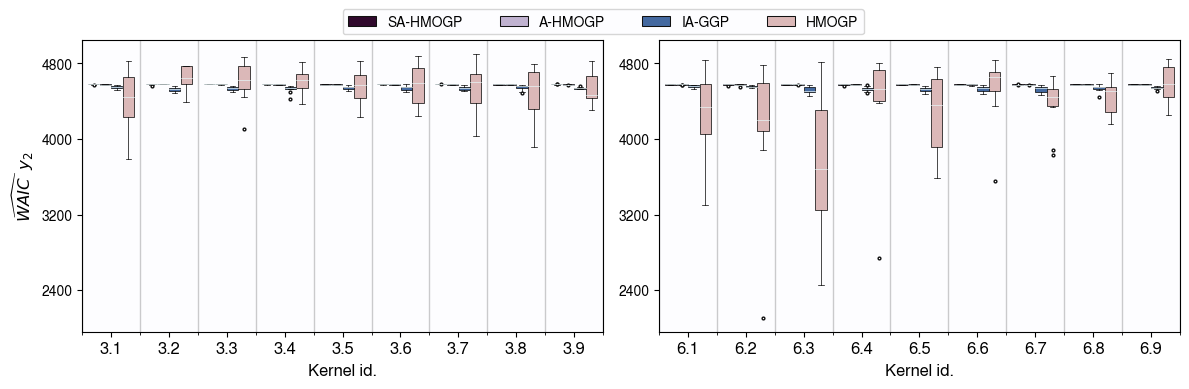

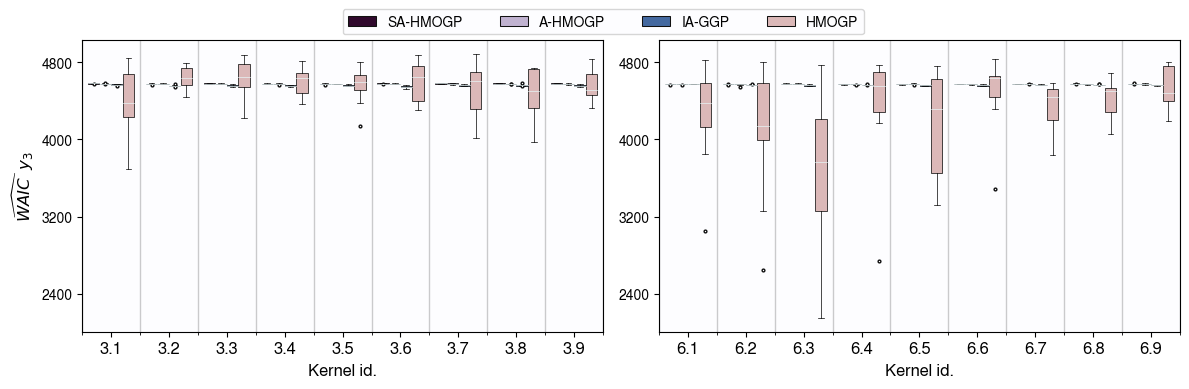

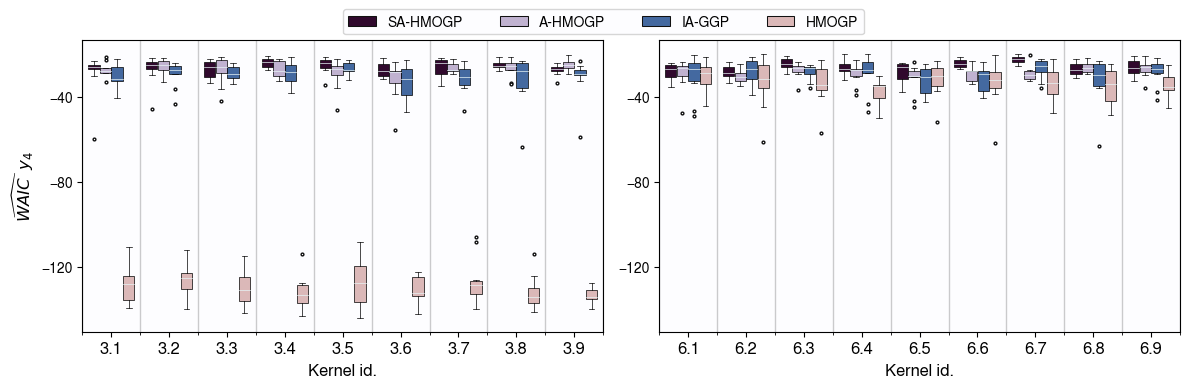

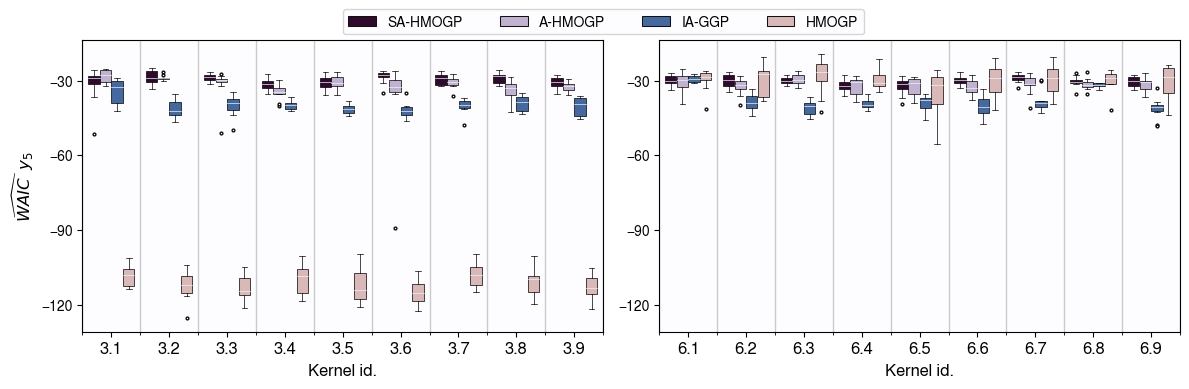

In [12]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']

for d, y in enumerate(waic_cols, start=1):
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
    for i, kcid_n in enumerate(kcid):
        
        sns.boxplot(data=waic[waic.kcid.isin(kcid_n)], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
        ax[i].get_legend().remove()
        
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
        ax[i].set_xlabel("Kernel id.")
        ax[i].set_ylabel("")                    # added
        yticks = ticker.MaxNLocator(n_ticks)    # added
        ax[i].yaxis.set_major_locator(yticks)   # added

    ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    ax[0].set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", d))      # added
    for axis in ax.flatten():
        axis.yaxis.set_tick_params(labelleft=True)
    fig.tight_layout()
    
    if savefig:
        fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y{d}_waic.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

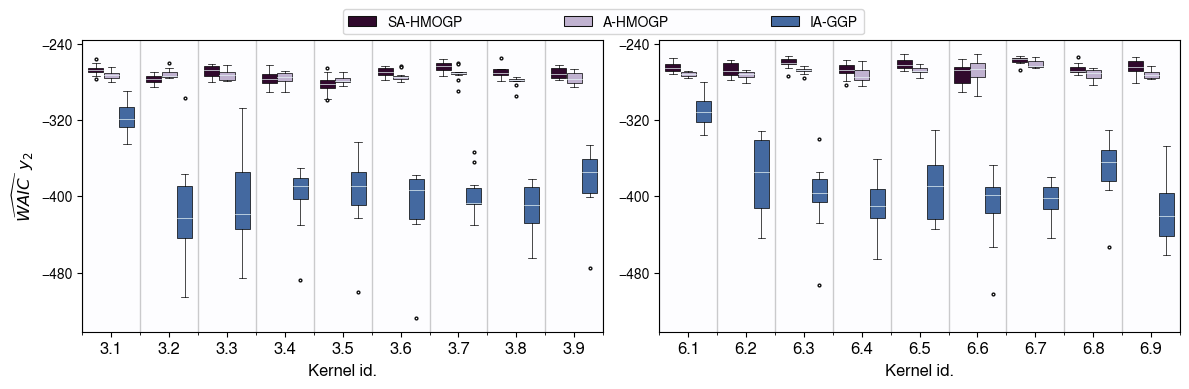

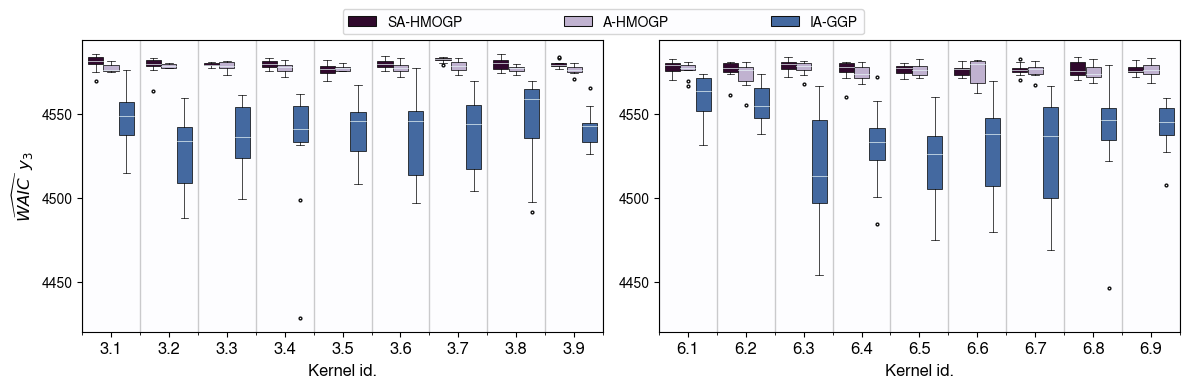

In [13]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
waic_cols = ['elpd_waic_y0', 'elpd_waic_y1', 'elpd_waic_y2','elpd_waic_y3', 'elpd_waic_y4']


idx = [2,3]
for d, y in zip(idx, waic_cols):
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
    for i, kcid_n in enumerate(kcid):
        
        sns.boxplot(data=waic[(waic.kcid.isin(kcid_n)) & (waic.test_id != "HMOGP")], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
        ax[i].get_legend().remove()
        
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
        ax[i].set_xlabel("Kernel id.")
        ax[i].set_ylabel("")                    # added
        yticks = ticker.MaxNLocator(n_ticks)    # added
        ax[i].yaxis.set_major_locator(yticks)   # added

    ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    ax[0].set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", d))      # added
    for axis in ax.flatten():
        axis.yaxis.set_tick_params(labelleft=True)
    fig.tight_layout()
        
        
    # sns.boxplot(data=waic, x="kcid", y=y, hue="test_id", ax=ax, palette=palette, **props)
    # ax.get_legend().remove()
    # ax.set_ylabel(r"${{\widehat{{{}}}}}$  $y_{}$".format("WAIC", d))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    # ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    # ax.set_xlabel("Kernel id.")
    # fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
    # fig.tight_layout()
    
    if savefig:
        fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y{d}_waic_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

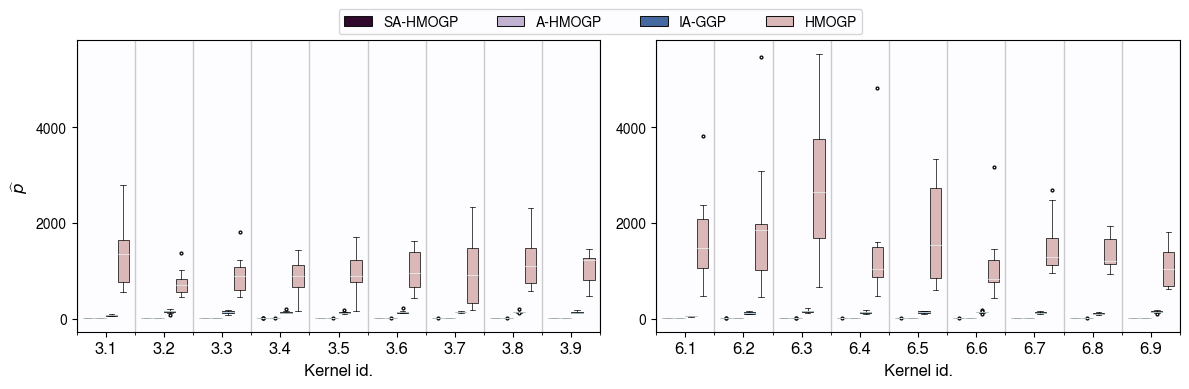

In [14]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=waic[waic.kcid.isin(kcid_n)], x="kcid", y="p_waic", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"${{\widehat{{{}}}}}$".format("p"))
for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_effective_n_param.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

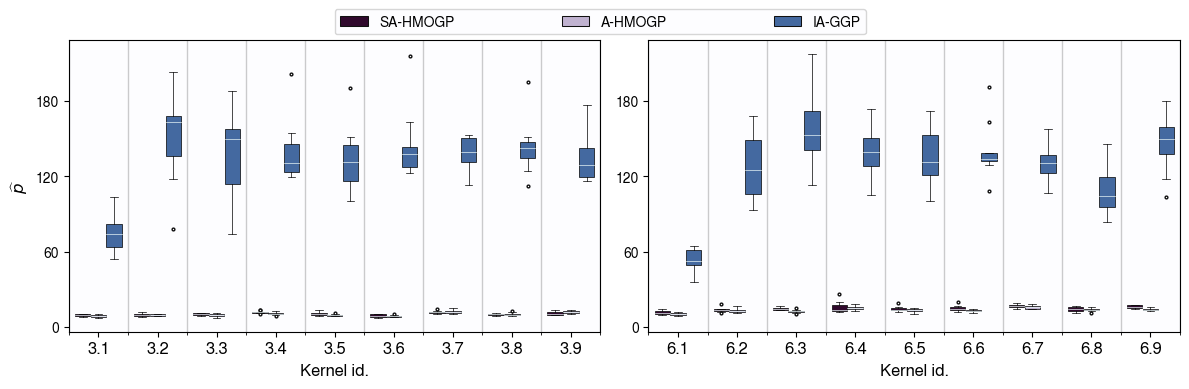

In [15]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=waic[(waic.kcid.isin(kcid_n)) & (waic.test_id != "HMOGP")], x="kcid", y="p_waic", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"${{\widehat{{{}}}}}$".format("p"))
for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_effective_n_param_additive.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

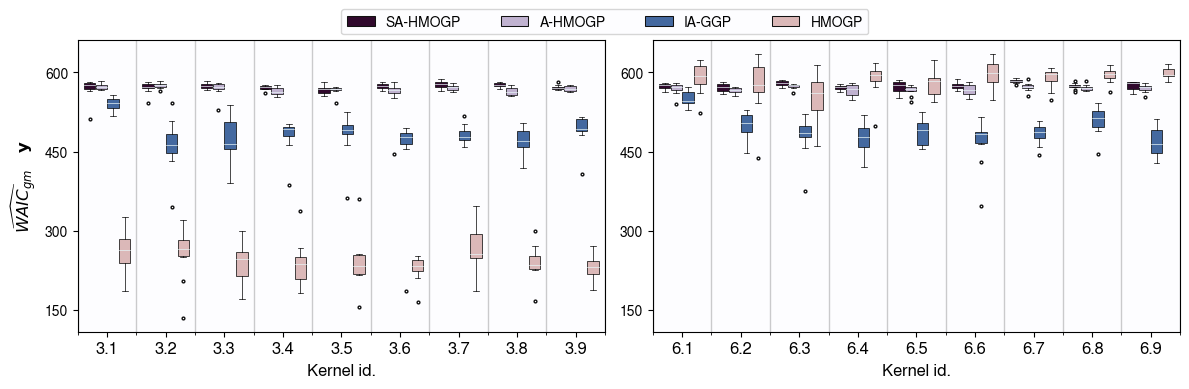

In [16]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=waic_gm[waic_gm.kcid.isin(kcid_n)], x="kcid", y="adj_elpd_waic", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added

ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"${{\widehat{{{}}}}}_{{gm}}$    $\mathbf{{y}}$".format("WAIC"))

for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
fig.tight_layout()

# sns.boxplot(data=waic_gm, x="kcid", y="adj_elpd_waic", hue="test_id", ax=ax, palette=palette, **props)
# ax.get_legend().remove()
# ax.set_ylabel(r"${{\widehat{{{}}}}}_{{gm}}$    $\mathbf{{y}}$".format("WAIC"))
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
# ax.set_xlabel("Kernel id.")
# fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
# fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_waic_gm.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

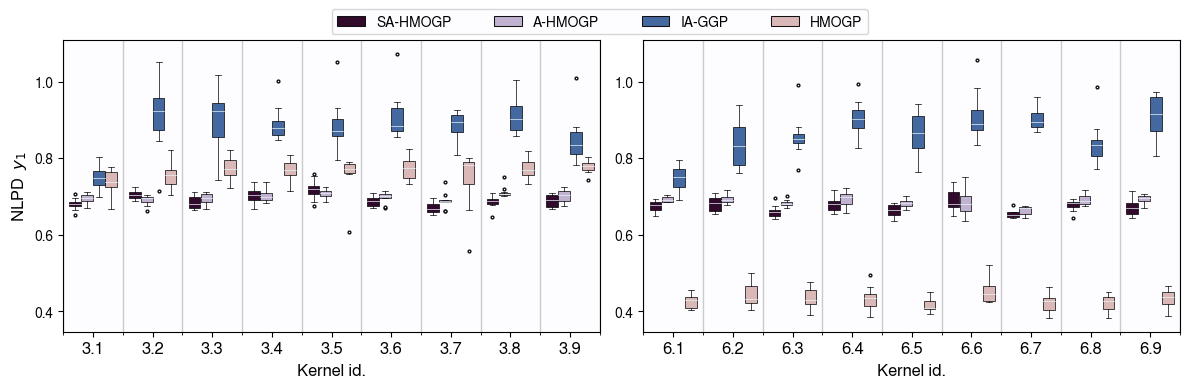

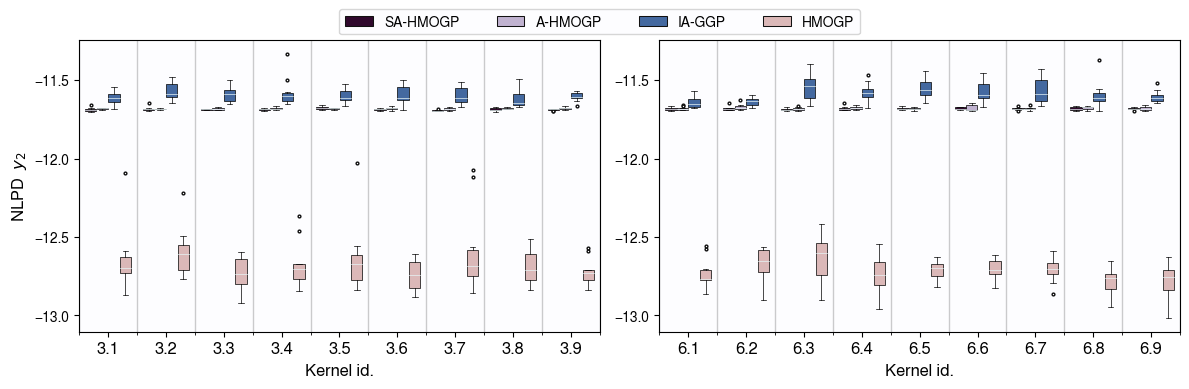

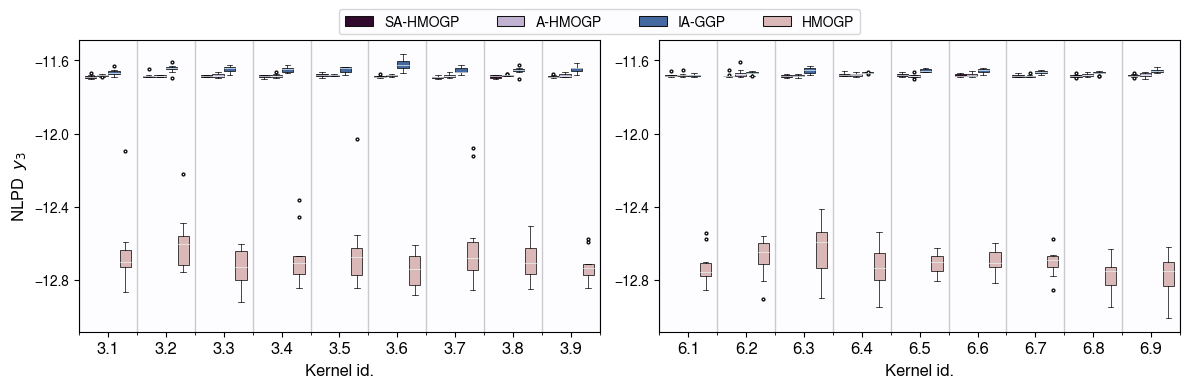

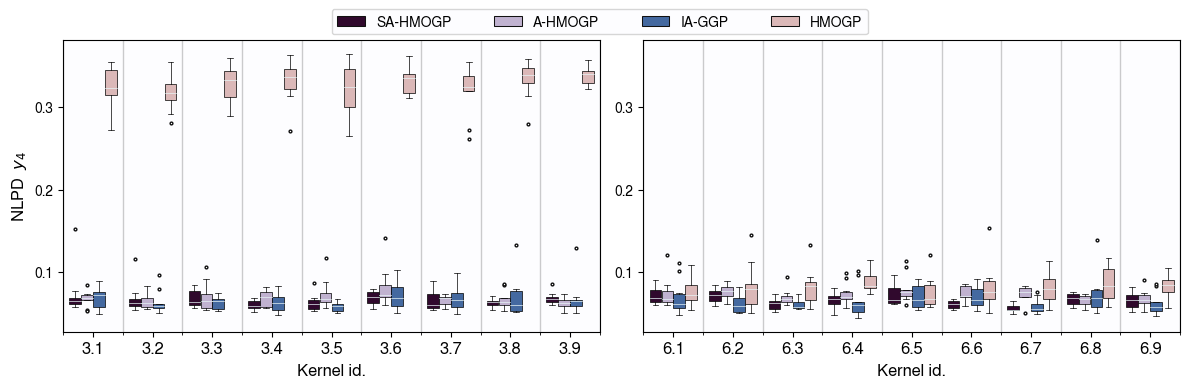

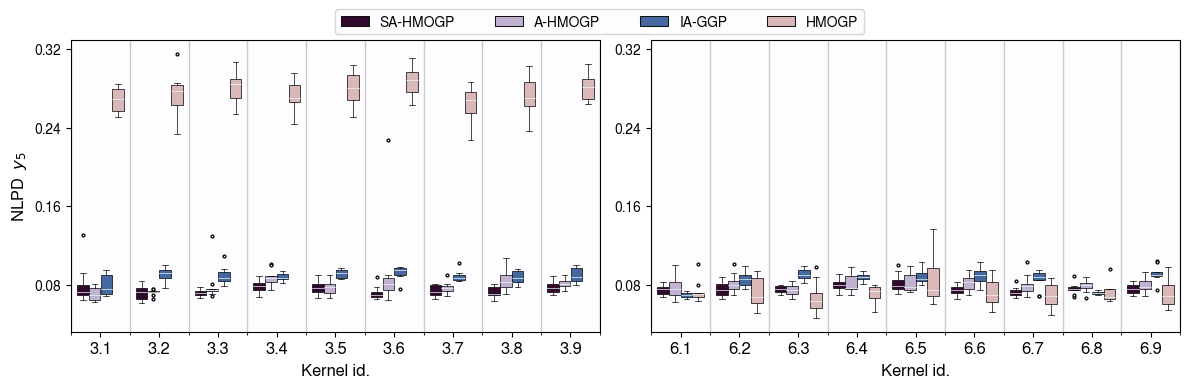

In [17]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}
nlpd_cols = ['y0', 'y1', 'y2', 'y3', 'y4']

for d, y in enumerate(nlpd_cols, start=1):
    fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
    for i, kcid_n in enumerate(kcid):
        sns.boxplot(data=nlpd[nlpd.kcid.isin(kcid_n)], x="kcid", y=y, hue="test_id", ax=ax[i], palette=palette, **props)
        ax[i].get_legend().remove()
        
        ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
        ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
        ax[i].set_xlabel("Kernel id.")
        ax[i].set_ylabel("")                    # added
        yticks = ticker.MaxNLocator(n_ticks)    # added
        ax[i].yaxis.set_major_locator(yticks)   # added

    ax[0].legend(bbox_to_anchor=(.5, 1.02, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
    ax[0].set_ylabel(r"NLPD  $y_{}$".format(d))      # added
    for axis in ax.flatten():
        axis.yaxis.set_tick_params(labelleft=True)
    fig.tight_layout()
    
    if savefig:
        fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y{d}_nlpd.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

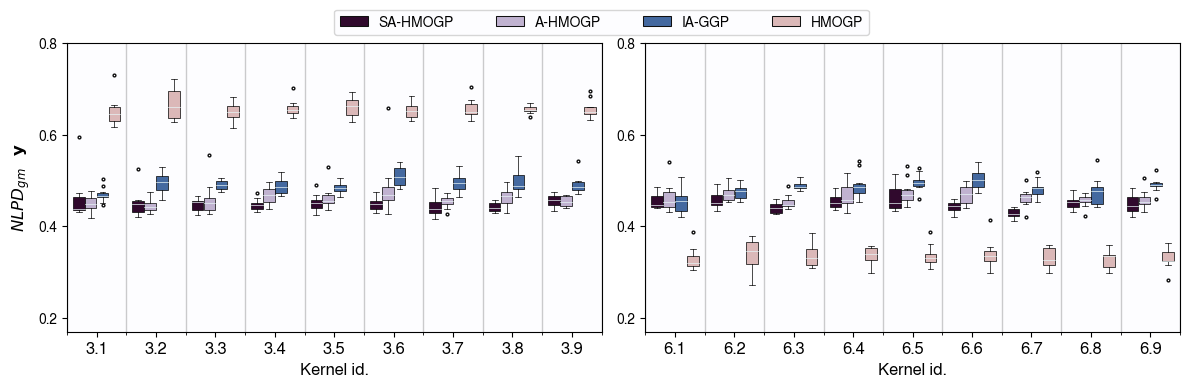

In [18]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.5, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(ncols=2, figsize=(12,4), sharey=True, sharex=False)
for i, kcid_n in enumerate(kcid):
    sns.boxplot(data=nlpd_gm[(nlpd_gm.kcid.isin(kcid_n))], x="kcid", y="adj_nlpd", hue="test_id", ax=ax[i], palette=palette, **props)
    ax[i].get_legend().remove()
    ax[i].xaxis.set_minor_locator(MultipleLocator(0.5))
    ax[i].xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
    ax[i].set_xlabel("Kernel id.")
    ax[i].set_ylabel("")                    # added
    yticks = ticker.MaxNLocator(n_ticks)    # added
    ax[i].yaxis.set_major_locator(yticks)   # added
    ax[i].set_ylim(.17,.8)

ax[0].legend(bbox_to_anchor=(.5, 1.03, 1, .05), loc=3, ncol=4, mode="expand", borderaxespad=0)                                                    # added
ax[0].set_ylabel(r"${{{}}}_{{{}}}$   $\mathbf{{y}}$".format("NLPD", "gm", i))
for axis in ax.flatten():
    axis.yaxis.set_tick_params(labelleft=True)
fig.tight_layout()


# fig, ax = plt.subplots(figsize=(4.5,4), sharey=True, sharex=True)
# sns.boxplot(data=nlpd_gm, x="kcid", y="adj_nlpd", hue="test_id", ax=ax, palette=palette, **props)
# ax.get_legend().remove()
# ax.set_ylabel(r"${{{}}}_{{{}}}$   $\mathbf{{y}}$".format("NLPD", "gm", i))
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
# ax.set_xlabel("Kernel id.")
# fig.legend(loc='lower center', bbox_to_anchor=(.55, .97), ncol=4, fontsize=10)
# fig.tight_layout()

if savefig:
    fig.savefig(os.path.join(save_image_path, f"kernel{kernel_n}_y_nlpd_gm.pdf"), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [19]:
compute_times = pd.concat([
    metrics3.compute_times,
    metrics6.compute_times,
])
compute_times = compute_times.reset_index(drop=True)

compute_times_sub0 = compute_times[(((compute_times.test_id == "HMOGP") & (compute_times.kcid.apply(lambda x: "6." in str(x)))) | ((compute_times.test_id != "HMOGP") & (compute_times.kcid.apply(lambda x: "3." in str(x)))))].copy()

compute_times_sub = compute_times[(compute_times.test_id != "IA-GGP") & (((compute_times.test_id == "HMOGP") & (compute_times.kcid.apply(lambda x: "6." in str(x)))) | ((compute_times.test_id != "HMOGP") & (compute_times.kcid.apply(lambda x: "3." in str(x)))))].copy()

kc = zip(np.arange(3.1, 4, .1), np.arange(6.1, 7, .1))
kclist = []
for kc3, kc6 in kc:
    kclist.extend([np.round(kc3,1), np.round(kc6,1)])

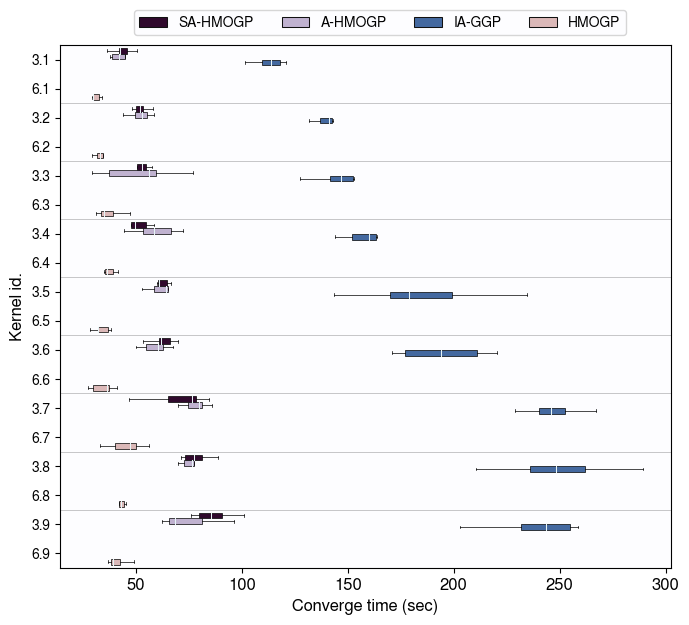

In [20]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.75, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,6), sharey=True, sharex=True)
sns.boxplot(data=compute_times_sub0, y="kcid", x="time_to_converge", hue="test_id", ax=ax, palette=palette, orient="h", order=kclist, showfliers=False, **props)
ax.set_xlim()
ax.get_legend().remove()
ax.set_xlabel("Converge time (sec)")
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ytick_sub = ax.get_yticks()[::2]
[ax.axhline(y+1.5,color='k', lw=.5, linestyle='-', alpha=.3) for y in ytick_sub]
ax.set_ylabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .98), ncol=4, fontsize=10)
# ax.set_xlim(0,320)
fig.tight_layout()

if savefig:
    filename = f"kernel{kernel_n}_compute_time.pdf"
    if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
        os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
        print("Deleted file:", filename[:-4] + ".png")
    fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

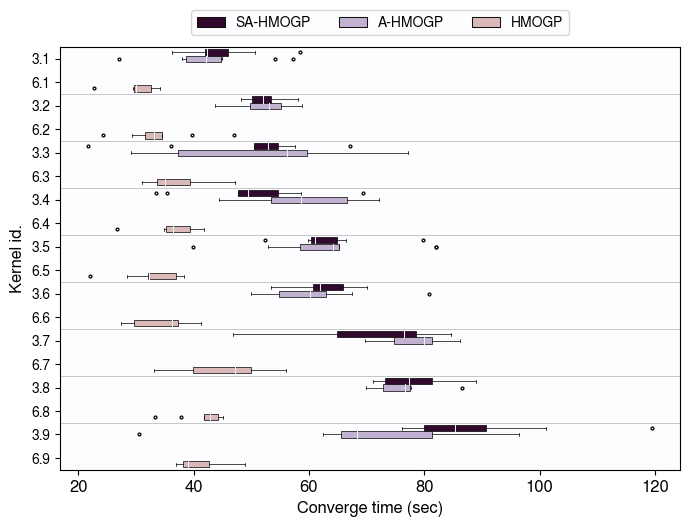

In [21]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.75, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,5), sharey=True, sharex=True)
sns.boxplot(data=compute_times_sub, y="kcid", x="time_to_converge", hue="test_id", ax=ax, palette=palette, orient="h", order=kclist, **props)
ax.get_legend().remove()
ax.set_xlabel("Converge time (sec)")
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ytick_sub = ax.get_yticks()[::2]
[ax.axhline(y+1.5,color='k', lw=.5, linestyle='-', alpha=.3) for y in ytick_sub]
ax.set_ylabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .98), ncol=4, fontsize=10)
# ax.set_xlim(0,320)
fig.tight_layout()

# if savefig:
#     filename = f"kernel{kernel_n}_compute_time.pdf"
#     if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
#         os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
#         print("Deleted file:", filename[:-4] + ".png")
#     fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [22]:
compute_times = pd.concat([
    metrics2.compute_times,
    metrics6.compute_times,
])
compute_times = compute_times.reset_index(drop=True)

compute_times_sub = compute_times[(compute_times.test_id != "IA-GGP") & (((compute_times.test_id == "HMOGP") & (compute_times.kcid.apply(lambda x: "6." in str(x)))) | ((compute_times.test_id != "HMOGP") & (compute_times.kcid.apply(lambda x: "2." in str(x)))))].copy()

compute_times_sub

kc = zip(np.arange(2.1, 3, .1), np.arange(6.1, 7, .1))
kclist = []
for kc2, kc6 in kc:
    kclist.extend([np.round(kc2,1), np.round(kc6,1)])

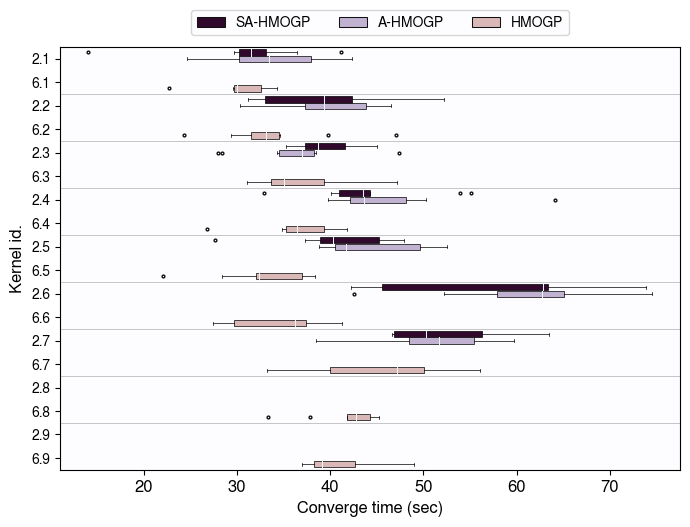

In [23]:
props = {
    'medianprops': {"color": "#E7F5F7", 'linewidth':.75, 'linestyle':'-'},
    'boxprops':{'edgecolor':'k', 'linewidth':.5},
    'whiskerprops':{'color':'k', 'linewidth':.5},
    'capprops':{'color':'k', 'linewidth':.5},
    'flierprops':{'markersize':2, 'marker':'o', 'markerfacecolor':'white', 'linewidth':.5},
}

fig, ax = plt.subplots(figsize=(7,5), sharey=True, sharex=True)
sns.boxplot(data=compute_times_sub, y="kcid", x="time_to_converge", hue="test_id", ax=ax, palette=palette, orient="h", order=kclist, **props)
ax.get_legend().remove()
ax.set_xlabel("Converge time (sec)")
# ax.xaxis.set_minor_locator(MultipleLocator(0.5))
# ax.xaxis.grid(True, which='minor', color='black', lw=1, linestyle='-', alpha=.2)
ytick_sub = ax.get_yticks()[::2]
[ax.axhline(y+1.5,color='k', lw=.5, linestyle='-', alpha=.3) for y in ytick_sub]
ax.set_ylabel("Kernel id.")
fig.legend(loc='lower center', bbox_to_anchor=(.55, .98), ncol=4, fontsize=10)
# ax.set_xlim(0,320)
fig.tight_layout()

# if savefig:
#     filename = f"kernel{kernel_n}_compute_time.pdf"
#     if os.path.exists(os.path.join(save_image_path, filename[:-4] + ".png")):
#         os.remove(os.path.join(save_image_path, filename[:-4] + ".png"))
#         print("Deleted file:", filename[:-4] + ".png")
#     fig.savefig(os.path.join(save_image_path, filename), dpi=dpi, pad_inches=0, bbox_inches='tight')

In [24]:
metrics18.compute_times[metrics18.compute_times.test_id=="HMOGP"]

,test_id,kcid,lmc_prior_code,lengthscale_prior_code,time_to_converge,iterations_to_converge
0,HMOGP,18.1,2.0,1.0,87.351017,945.0
0,HMOGP,18.1,2.0,1.0,88.652984,953.0
0,HMOGP,18.1,2.0,1.0,86.857768,945.0
0,HMOGP,18.1,2.0,1.0,95.685942,1034.0
0,HMOGP,18.1,2.0,1.0,160.324555,973.0
0,HMOGP,18.1,2.0,1.0,90.293740,973.0
0,HMOGP,18.1,2.0,1.0,109.567189,860.0
0,HMOGP,18.1,2.0,1.0,81.159967,953.0
0,HMOGP,18.1,2.0,1.0,79.805040,953.0
0,HMOGP,18.1,2.0,1.0,80.023691,953.0


In [25]:
metrics18.waic_gm[metrics18.waic_gm.test_id=="HMOGP"]

,test_id,kcid,lmc_prior_code,lengthscale_prior_code,test_data,elpd_waic,p_waic,se,warning,n_data_points,n_samples,scale,elpd_waic_y0,elpd_waic_y1,elpd_waic_y2,elpd_waic_y3,elpd_waic_y4,adj_elpd_waic
0,HMOGP,18.1,2,1,1,-29068.187110,39254.001376,24239.602300,True,1960,300,log,153.96457,1.00000,1.00000,31.45477,24.21403,10.3237
0,HMOGP,18.1,2,1,1,7482.660566,2620.309604,815.426474,True,1960,300,log,131.06845,16103.62458,20475.93581,26.41489,25.43732,492.7165
0,HMOGP,18.1,2,1,1,6835.019106,3222.351142,754.080869,True,1960,300,log,144.00600,15838.21826,20081.14668,30.29414,21.17450,493.8664
0,HMOGP,18.1,2,1,1,8491.184141,1511.590852,428.806321,True,1960,300,log,143.03441,16801.36084,20777.81006,25.82467,22.97465,494.6906
0,HMOGP,18.1,2,1,1,7376.394726,2753.759425,1203.760253,True,1960,300,log,150.01651,16120.37035,20346.18695,19.62199,20.01940,454.1907
0,HMOGP,18.1,2,1,1,8464.964056,1546.775331,426.663373,True,1960,300,log,165.87368,16622.32022,20921.92862,13.13611,21.52591,439.0357
0,HMOGP,18.1,2,1,1,8290.911621,1871.281550,625.625242,True,1960,300,log,153.46005,16513.99408,20857.50145,28.72298,17.05355,481.5383
0,HMOGP,18.1,2,1,1,7843.885008,2302.334763,530.524186,True,1960,300,log,153.24039,16368.41585,20557.68643,19.05621,25.30661,477.6667
0,HMOGP,18.1,2,1,1,7503.072302,2433.161379,993.710127,True,1960,300,log,146.73130,16466.44800,20121.37679,25.93509,22.40160,489.9925
0,HMOGP,18.1,2,1,1,8888.628097,1133.106273,366.208679,True,1960,300,log,153.83891,16864.65500,21103.99416,23.84524,22.11526,492.1533


In [26]:
metrics6.waic

,test_id,kcid,lmc_prior_code,lengthscale_prior_code,test_data,elpd_waic,p_waic,se,warning,n_data_points,n_samples,scale,elpd_waic_y0,elpd_waic_y1,elpd_waic_y2,elpd_waic_y3,elpd_waic_y4,subset
0,SA-HMOGP,6.1,2,1,1,8839.814290,9.748083,283.060730,False,1960,300,log,-267.15879,4582.64057,4579.19598,-24.08108,-30.78239,0.6
1,SA-HMOGP,6.1,2,1,1,8839.956409,10.898188,283.378253,False,1960,300,log,-264.87934,4580.76016,4578.32555,-27.27576,-26.97420,0.6
2,SA-HMOGP,6.1,2,1,1,8833.881851,13.833657,283.204520,False,1960,300,log,-260.92439,4575.60890,4577.22700,-24.36222,-33.66744,0.6
3,SA-HMOGP,6.1,2,1,1,8845.792469,14.219758,283.139518,False,1960,300,log,-260.65090,4580.58075,4580.54482,-27.34457,-27.33763,0.6
4,SA-HMOGP,6.1,2,1,1,8840.381808,13.359384,283.106266,False,1960,300,log,-255.08947,4582.92252,4575.27168,-32.17122,-30.55170,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,HMOGP,6.9,2,1,1,8276.080414,1809.408580,492.583165,True,1960,300,log,-175.85062,4320.47866,4190.78401,-34.64616,-24.68548,0.6
356,HMOGP,6.9,2,1,1,8828.278479,1061.706516,487.743284,True,1960,300,log,-166.67829,4613.77206,4439.16877,-26.95983,-31.02423,0.6
357,HMOGP,6.9,2,1,1,9385.799159,733.435734,314.331421,True,1960,300,log,-190.33440,4843.54576,4809.35407,-35.78362,-40.98265,0.6
358,HMOGP,6.9,2,1,1,8834.156024,1001.539122,341.864509,True,1960,300,log,-181.28320,4542.66774,4534.80200,-37.10242,-24.92810,0.6
